In [ ]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.CodeMirror {font-family:Consolas; font-size:17pt;}
div.output {font-size:17pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:17pt;}
div.prompt {min-width:70px;}
</style>
"""))

**<font size="6" color="red">ch4. RNN(순환신경망)</font>**

# 1. 문맥을 이용하여 모델만들기

In [15]:
text = """경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다
"""

In [7]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])[0]
print(encoded)
print(t.word_index)

[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [12]:
t.texts_to_sequences(['경마장에 있는 말이 뛰고 있다'])[0]

[2, 3, 1, 4, 5]

In [19]:
# 
sequences = []
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]
    print('원래 문장 :',line)
    print('encoed 문장 :', encoded)
    for i in range(0, len(encoded)-1):
        for j in range(i+2, len(encoded)+1):
            sequences.append(encoded[i:j])
print()
for sequence in sequences:
    print('[', end='')
    for word_seq in sequence:
        for key, value in t.word_index.items():
            if value==word_seq:
                print("{}:{}".format(value, key), end='  ')
    print(']')

원래 문장 : 경마장에 있는 말이 뛰고 있다
encoed 문장 : [2, 3, 1, 4, 5]
원래 문장 : 그의 말이 법이다
encoed 문장 : [6, 1, 7]
원래 문장 : 가는 말이 고와야 오는 말이 곱다
encoed 문장 : [8, 1, 9, 10, 1, 11]
원래 문장 : 
encoed 문장 : []

[2:경마장에  3:있는  ]
[2:경마장에  3:있는  1:말이  ]
[2:경마장에  3:있는  1:말이  4:뛰고  ]
[2:경마장에  3:있는  1:말이  4:뛰고  5:있다  ]
[3:있는  1:말이  ]
[3:있는  1:말이  4:뛰고  ]
[3:있는  1:말이  4:뛰고  5:있다  ]
[1:말이  4:뛰고  ]
[1:말이  4:뛰고  5:있다  ]
[4:뛰고  5:있다  ]
[6:그의  1:말이  ]
[6:그의  1:말이  7:법이다  ]
[1:말이  7:법이다  ]
[8:가는  1:말이  ]
[8:가는  1:말이  9:고와야  ]
[8:가는  1:말이  9:고와야  10:오는  ]
[8:가는  1:말이  9:고와야  10:오는  1:말이  ]
[8:가는  1:말이  9:고와야  10:오는  1:말이  11:곱다  ]
[1:말이  9:고와야  ]
[1:말이  9:고와야  10:오는  ]
[1:말이  9:고와야  10:오는  1:말이  ]
[1:말이  9:고와야  10:오는  1:말이  11:곱다  ]
[9:고와야  10:오는  ]
[9:고와야  10:오는  1:말이  ]
[9:고와야  10:오는  1:말이  11:곱다  ]
[10:오는  1:말이  ]
[10:오는  1:말이  11:곱다  ]
[1:말이  11:곱다  ]


In [20]:
sequences

[[2, 3],
 [2, 3, 1],
 [2, 3, 1, 4],
 [2, 3, 1, 4, 5],
 [3, 1],
 [3, 1, 4],
 [3, 1, 4, 5],
 [1, 4],
 [1, 4, 5],
 [4, 5],
 [6, 1],
 [6, 1, 7],
 [1, 7],
 [8, 1],
 [8, 1, 9],
 [8, 1, 9, 10],
 [8, 1, 9, 10, 1],
 [8, 1, 9, 10, 1, 11],
 [1, 9],
 [1, 9, 10],
 [1, 9, 10, 1],
 [1, 9, 10, 1, 11],
 [9, 10],
 [9, 10, 1],
 [9, 10, 1, 11],
 [10, 1],
 [10, 1, 11],
 [1, 11]]

In [24]:
print([len(s) for s in sequences])

[2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 2, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2]


In [26]:
# sequences에 제일 많은 단어가 들어 있는 갯수# sequences에 제일 많은 단어가 들어 있는 갯수
maxlen = max([len(s) for s in sequences])
maxlen

6

In [28]:
type(sequences), len(sequences)

(list, 28)

In [29]:
# sequences를 훈련가능한 데이터로 만들기
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = pad_sequences(sequences=sequences, 
                         maxlen=maxlen, 
                         padding='pre')
type(sequences), len(sequences), sequences

(numpy.ndarray,
 28,
 array([[ 0,  0,  0,  0,  2,  3],
        [ 0,  0,  0,  2,  3,  1],
        [ 0,  0,  2,  3,  1,  4],
        [ 0,  2,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  3,  1,  4],
        [ 0,  0,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  1,  4],
        [ 0,  0,  0,  1,  4,  5],
        [ 0,  0,  0,  0,  4,  5],
        [ 0,  0,  0,  0,  6,  1],
        [ 0,  0,  0,  6,  1,  7],
        [ 0,  0,  0,  0,  1,  7],
        [ 0,  0,  0,  0,  8,  1],
        [ 0,  0,  0,  8,  1,  9],
        [ 0,  0,  8,  1,  9, 10],
        [ 0,  8,  1,  9, 10,  1],
        [ 8,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  1,  9],
        [ 0,  0,  0,  1,  9, 10],
        [ 0,  0,  1,  9, 10,  1],
        [ 0,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  9, 10],
        [ 0,  0,  0,  9, 10,  1],
        [ 0,  0,  9, 10,  1, 11],
        [ 0,  0,  0,  0, 10,  1],
        [ 0,  0,  0, 10,  1, 11],
        [ 0,  0,  0,  0,  1, 11]]))

In [32]:
# 독립변수(X)와 종속변수(Y) 분리
X = sequences[:, :-1]
Y = sequences[:, -1]
Y

array([ 3,  1,  4,  5,  1,  4,  5,  4,  5,  5,  1,  7,  7,  1,  9, 10,  1,
       11,  9, 10,  1, 11, 10,  1, 11,  1, 11, 11])

In [34]:
print(t.word_index)

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [35]:
vocab_size = len(t.word_index)+1
vocab_size

12

In [36]:
# Y 원핫인코딩
from tensorflow.keras.utils import to_categorical
Y = to_categorical(Y, num_classes=vocab_size)
Y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [38]:
X.shape[1]

5

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding

# RNN 모델 생성
model = Sequential()
# 희소행렬로 변환 (10:벡터)
model.add(Embedding(vocab_size, 10, input_length=X.shape[1]))
model.add(SimpleRNN(32))
model.add(Dense(vocab_size, activation="softmax"))

# 모델 학습과정 설정
model.compile(loss="categorical_crossentropy", optimizer="adam", 
              metrics=['accuracy'])

# 학습시키기
hist = model.fit(X, Y, epochs=300, verbose=2)

Epoch 1/300
1/1 - 1s - loss: 2.4904 - accuracy: 0.1429
Epoch 2/300
1/1 - 0s - loss: 2.4785 - accuracy: 0.2143
Epoch 3/300
1/1 - 0s - loss: 2.4665 - accuracy: 0.2857
Epoch 4/300
1/1 - 0s - loss: 2.4544 - accuracy: 0.2857
Epoch 5/300
1/1 - 0s - loss: 2.4419 - accuracy: 0.3214
Epoch 6/300
1/1 - 0s - loss: 2.4291 - accuracy: 0.3214
Epoch 7/300
1/1 - 0s - loss: 2.4159 - accuracy: 0.2857
Epoch 8/300
1/1 - 0s - loss: 2.4022 - accuracy: 0.2857
Epoch 9/300
1/1 - 0s - loss: 2.3879 - accuracy: 0.3214
Epoch 10/300
1/1 - 0s - loss: 2.3730 - accuracy: 0.3214
Epoch 11/300
1/1 - 0s - loss: 2.3574 - accuracy: 0.3214
Epoch 12/300
1/1 - 0s - loss: 2.3410 - accuracy: 0.3214
Epoch 13/300
1/1 - 0s - loss: 2.3238 - accuracy: 0.3214
Epoch 14/300
1/1 - 0s - loss: 2.3058 - accuracy: 0.3214
Epoch 15/300
1/1 - 0s - loss: 2.2871 - accuracy: 0.3214
Epoch 16/300
1/1 - 0s - loss: 2.2675 - accuracy: 0.2857
Epoch 17/300
1/1 - 0s - loss: 2.2473 - accuracy: 0.2857
Epoch 18/300
1/1 - 0s - loss: 2.2266 - accuracy: 0.2857
E

Epoch 147/300
1/1 - 0s - loss: 0.7634 - accuracy: 0.8214
Epoch 148/300
1/1 - 0s - loss: 0.7572 - accuracy: 0.8214
Epoch 149/300
1/1 - 0s - loss: 0.7510 - accuracy: 0.8214
Epoch 150/300
1/1 - 0s - loss: 0.7449 - accuracy: 0.8214
Epoch 151/300
1/1 - 0s - loss: 0.7389 - accuracy: 0.8214
Epoch 152/300
1/1 - 0s - loss: 0.7330 - accuracy: 0.8214
Epoch 153/300
1/1 - 0s - loss: 0.7271 - accuracy: 0.8214
Epoch 154/300
1/1 - 0s - loss: 0.7212 - accuracy: 0.8214
Epoch 155/300
1/1 - 0s - loss: 0.7155 - accuracy: 0.8214
Epoch 156/300
1/1 - 0s - loss: 0.7098 - accuracy: 0.8214
Epoch 157/300
1/1 - 0s - loss: 0.7041 - accuracy: 0.8214
Epoch 158/300
1/1 - 0s - loss: 0.6985 - accuracy: 0.8214
Epoch 159/300
1/1 - 0s - loss: 0.6930 - accuracy: 0.8214
Epoch 160/300
1/1 - 0s - loss: 0.6875 - accuracy: 0.8214
Epoch 161/300
1/1 - 0s - loss: 0.6821 - accuracy: 0.8214
Epoch 162/300
1/1 - 0s - loss: 0.6767 - accuracy: 0.8214
Epoch 163/300
1/1 - 0s - loss: 0.6714 - accuracy: 0.8214
Epoch 164/300
1/1 - 0s - loss: 

Epoch 291/300
1/1 - 0s - loss: 0.3152 - accuracy: 0.8929
Epoch 292/300
1/1 - 0s - loss: 0.3141 - accuracy: 0.8929
Epoch 293/300
1/1 - 0s - loss: 0.3129 - accuracy: 0.8929
Epoch 294/300
1/1 - 0s - loss: 0.3118 - accuracy: 0.8929
Epoch 295/300
1/1 - 0s - loss: 0.3106 - accuracy: 0.8929
Epoch 296/300
1/1 - 0s - loss: 0.3095 - accuracy: 0.8929
Epoch 297/300
1/1 - 0s - loss: 0.3084 - accuracy: 0.8929
Epoch 298/300
1/1 - 0s - loss: 0.3073 - accuracy: 0.8929
Epoch 299/300
1/1 - 0s - loss: 0.3063 - accuracy: 0.8929
Epoch 300/300
1/1 - 0s - loss: 0.3052 - accuracy: 0.8929


In [40]:
# 모델 평가
model.evaluate(X, Y)

1/1 [==============================] - 0s 231ms/step - loss: 0.3041 - accuracy: 0.8929


[0.30412811040878296, 0.8928571343421936]

In [41]:
hist.history.keys()

dict_keys(['loss', 'accuracy'])

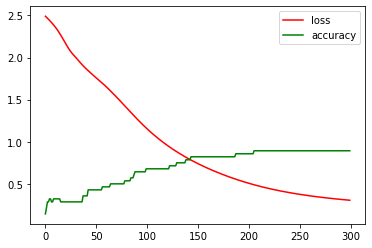

In [42]:
# 학습과정 보기
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], color='r', label="loss")
plt.plot(hist.history['accuracy'], color='g', label='accuracy')
plt.legend()

In [51]:
# '경마장에' 뒤에 나오는 단어를 model에 의해 추측
encoded = t.texts_to_sequences(['경마장에'])[0]
encoded = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict_classes(encoded)
print('예측결과값 :',result[0])
for key, value in t.word_index.items():
    if value==result[0]:
        print("예측된 단어 :", key)
        break

예측결과값 : 3
예측된 단어 : 있는


C:\Users\tjoeun\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [56]:
# 입력받은 다음 단어 추측하기
word = input("입력 단어 :")
encoded = t.texts_to_sequences([word])[0]
encoded = pad_sequences([encoded], maxlen=5, padding='pre')
result = np.argmax(model.predict(encoded))
print('예측결과값 :',result)
for key, value in t.word_index.items():
    if value==result:
        print("예측된 단어 :", key)
        break

입력 단어 :말이
예측결과값 : 9
예측된 단어 : 고와야


# 2. 다음 문맥 예측해 보기

In [57]:
# "경마장에" 이후에 올 단어  4개 예측 => 경마장에 있는 말이 뛰고
#  -----                   --
def sentence_generation(model, t, current_word, n):
    init_word = current_word
    print("입력 단어 :", init_word)
    setence = ""
    for i in range(1,n+1):
        encoded = t.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=5, padding='pre')
        result = np.argmax(model.predict(encoded))
        for word, index in t.word_index.items():
            if index==result:
                print("{}번째 : {}:{}".format(i, word, result))
                current_word = current_word + ' ' + word
                break;
    return current_word

In [60]:
sentence_generation(model, t, "경마장에", 4)

입력 단어 : 경마장에
1번째 : 있는:3
2번째 : 말이:1
3번째 : 뛰고:4
4번째 : 있다:5


'경마장에 있는 말이 뛰고 있다'

In [61]:
sentence_generation(model, t, "가는 말이", 4)

입력 단어 : 가는 말이
1번째 : 고와야:9
2번째 : 오는:10
3번째 : 말이:1
4번째 : 곱다:11


'가는 말이 고와야 오는 말이 곱다'

# 3. LSTM

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM

# RNN 모델 생성
model = Sequential()
# 희소행렬로 변환 (10:벡터)
model.add(Embedding(vocab_size, 10, input_length=X.shape[1]))
model.add(LSTM(32))
model.add(Dense(vocab_size, activation="softmax"))

# 모델 학습과정 설정
model.compile(loss="categorical_crossentropy", optimizer="adam", 
              metrics=['accuracy'])

# 학습시키기
hist = model.fit(X, Y, epochs=300, verbose=2)

Epoch 1/300
1/1 - 2s - loss: 2.4835 - accuracy: 0.0000e+00
Epoch 2/300
1/1 - 0s - loss: 2.4787 - accuracy: 0.0357
Epoch 3/300
1/1 - 0s - loss: 2.4740 - accuracy: 0.0714
Epoch 4/300
1/1 - 0s - loss: 2.4692 - accuracy: 0.1429
Epoch 5/300
1/1 - 0s - loss: 2.4644 - accuracy: 0.1786
Epoch 6/300
1/1 - 0s - loss: 2.4595 - accuracy: 0.3929
Epoch 7/300
1/1 - 0s - loss: 2.4546 - accuracy: 0.3929
Epoch 8/300
1/1 - 0s - loss: 2.4495 - accuracy: 0.3929
Epoch 9/300
1/1 - 0s - loss: 2.4444 - accuracy: 0.4643
Epoch 10/300
1/1 - 0s - loss: 2.4391 - accuracy: 0.4643
Epoch 11/300
1/1 - 0s - loss: 2.4337 - accuracy: 0.4643
Epoch 12/300
1/1 - 0s - loss: 2.4282 - accuracy: 0.4643
Epoch 13/300
1/1 - 0s - loss: 2.4225 - accuracy: 0.3929
Epoch 14/300
1/1 - 0s - loss: 2.4166 - accuracy: 0.3214
Epoch 15/300
1/1 - 0s - loss: 2.4105 - accuracy: 0.3214
Epoch 16/300
1/1 - 0s - loss: 2.4042 - accuracy: 0.3214
Epoch 17/300
1/1 - 0s - loss: 2.3977 - accuracy: 0.3214
Epoch 18/300
1/1 - 0s - loss: 2.3909 - accuracy: 0.32

Epoch 147/300
1/1 - 0s - loss: 0.9586 - accuracy: 0.7500
Epoch 148/300
1/1 - 0s - loss: 0.9442 - accuracy: 0.7857
Epoch 149/300
1/1 - 0s - loss: 0.9301 - accuracy: 0.7857
Epoch 150/300
1/1 - 0s - loss: 0.9162 - accuracy: 0.7857
Epoch 151/300
1/1 - 0s - loss: 0.9027 - accuracy: 0.7857
Epoch 152/300
1/1 - 0s - loss: 0.8895 - accuracy: 0.7857
Epoch 153/300
1/1 - 0s - loss: 0.8766 - accuracy: 0.7857
Epoch 154/300
1/1 - 0s - loss: 0.8639 - accuracy: 0.7857
Epoch 155/300
1/1 - 0s - loss: 0.8516 - accuracy: 0.7857
Epoch 156/300
1/1 - 0s - loss: 0.8395 - accuracy: 0.7857
Epoch 157/300
1/1 - 0s - loss: 0.8277 - accuracy: 0.7857
Epoch 158/300
1/1 - 0s - loss: 0.8162 - accuracy: 0.7857
Epoch 159/300
1/1 - 0s - loss: 0.8050 - accuracy: 0.7857
Epoch 160/300
1/1 - 0s - loss: 0.7940 - accuracy: 0.7857
Epoch 161/300
1/1 - 0s - loss: 0.7833 - accuracy: 0.7857
Epoch 162/300
1/1 - 0s - loss: 0.7728 - accuracy: 0.7857
Epoch 163/300
1/1 - 0s - loss: 0.7625 - accuracy: 0.7857
Epoch 164/300
1/1 - 0s - loss: 

Epoch 291/300
1/1 - 0s - loss: 0.2980 - accuracy: 0.8929
Epoch 292/300
1/1 - 0s - loss: 0.2964 - accuracy: 0.8929
Epoch 293/300
1/1 - 0s - loss: 0.2949 - accuracy: 0.8929
Epoch 294/300
1/1 - 0s - loss: 0.2933 - accuracy: 0.8929
Epoch 295/300
1/1 - 0s - loss: 0.2919 - accuracy: 0.8929
Epoch 296/300
1/1 - 0s - loss: 0.2904 - accuracy: 0.8929
Epoch 297/300
1/1 - 0s - loss: 0.2889 - accuracy: 0.8929
Epoch 298/300
1/1 - 0s - loss: 0.2875 - accuracy: 0.8929
Epoch 299/300
1/1 - 0s - loss: 0.2861 - accuracy: 0.8929
Epoch 300/300
1/1 - 0s - loss: 0.2847 - accuracy: 0.8929
